In [156]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

In [157]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.001)
                
def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))
    return inps


## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 



In [17]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms)
rp = generate_other_reverse_primitives('+', all_syms)
print(primitives)
print(rp)
testseqs = generate_trials(ops, all_syms, all_syms)

{'A': 9, 'B': 11, 'C': 13, 'D': 16}
[['A', '=', 9], ['B', '=', 11], ['C', '=', 13], ['D', '=', 16]]
[['A', ('+', 'C'), '=', 22], ['B', ('+', 'D'), '=', 27]]


In [225]:
valset_idx

[0, 3, 4, 5, 8, 9, 10, 13, 14, 15]

In [6]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

In [226]:
## calculate distance matrices for all models and steps 

def calculate_RDMs(res):
    ## find indices of 100% acc rnns
    acc_df = res['acc_df']
    all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
    print('no. 100% trained RNNs: ', len(all_acc_mods))

    mod_list = all_acc_mods # choose only rnns trained to 100%
    # mod_list = np.arange(num_sims)

    # initialise empty lists/arrays
    rdms = [[] for _ in range(4)]
    rdms_p = [[] for _ in range(4)]

    # extracts results from dictionary
    mods = res['mods']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    testseq = generate_trials(ops, all_syms, all_syms)
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}

# for ranked control
rank_dict = {'A': -1.5, 'B': -0.5, 'C': 0.5, 'D': 1.5}

# for selecting untrained trials
rp = generate_other(ops, all_syms) + generate_other_reverse_primitives('+', all_syms)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

def regress_RDM_abs(time_step, rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = []
        y = []
        for p in valset_idx:
            for q in valset_idx:
                x.append(rdm[time_step][i][p,q])
                y.append(truth_RDM[p,q])
        x = np.array(x).reshape(-1,1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs

# def regress_RDM_abs_init(time_step, rdm, ft_cue_dicts, ranked = False):
#     rs = []
#     for i, cuedict in enumerate(ft_cue_dicts):
#         if ranked:
#             curr_tests = change_dict(testseqs, rank_dict)
#         else:
#             curr_tests = change_dict(testseqs, cuedict)
#         init_tests = [[t[0]]+['='] for t in curr_tests ]
#         truth_outs = [calculate_output(t, cuedict) for t in init_tests]
#         truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
#         x = rdm[time_step][i].reshape(-1,1)
#         y = truth_RDM.reshape(16*16)
#         model = LinearRegression().fit(x, y)
#         r_sq = model.score(x, y)
#         rs.append(r_sq)
#     return rs

In [203]:
def truth_RDM_init(rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        init_tests = [[t[0]]+['='] for t in curr_tests ]
        truth_outs = [calculate_output(t, cuedict) for t in init_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        rs.append(truth_RDM)
    return rs

def truth_RDM(rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        rs.append(truth_RDM)
    return rs


# Read data

In [8]:
# read data

save_dir = '../results/representation_analysis/'

with open(save_dir+'other/res_other', 'rb') as f:
    res1 = pickle.load(f)
    
with open(save_dir+'full/res_full', 'rb') as f:
    res2 = pickle.load(f)
    
with open(save_dir+'balanced_other/res_balanced', 'rb') as f:
    res3 = pickle.load(f)

## Other

In [251]:
res = calculate_RDMs(res1)
rdms = res['rdms']
rdms_p = res['rdms_p']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]
truth_list = [np.array(truth_RDM(t, rdms, cue_dicts)).mean(axis=0) for t in range(4)]

no. 100% trained RNNs:  526


In [252]:
# find indices of untrained trials
rp = generate_other(ops, all_syms) + generate_primitives(all_syms)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

In [253]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(matlist[3])
print('no prims:   ', pca.explained_variance_ratio_)
pca = PCA(n_components=3)
pca.fit(matlist_p[3])
print('with prims:   ', pca.explained_variance_ratio_)

no prims:    [0.79195746 0.17909681 0.01954567]
with prims:    [0.71588742 0.2466732  0.01083627]


Text(0.5, 0.98, '2D-MDS: Other training; without primitives')

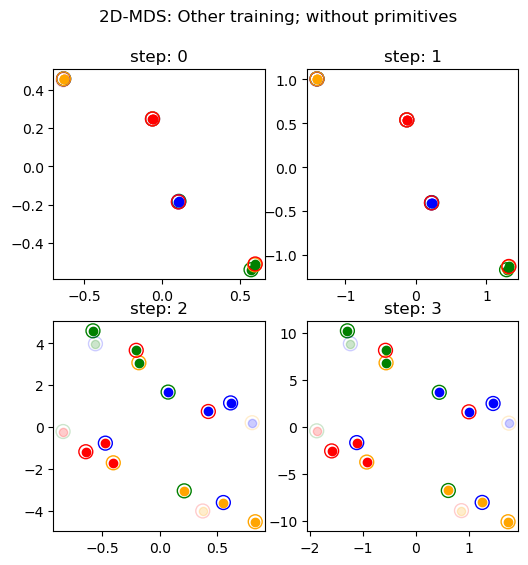

In [255]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; without primitives')
 

Text(0.5, 0.98, '2D-MDS: Other training; with primitives')

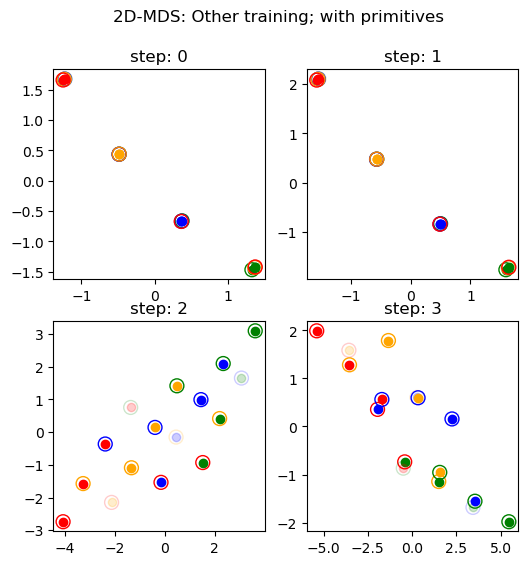

In [256]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; with primitives')


## Full

In [181]:
res = calculate_RDMs(res2)
rdms = res['rdms']
rdms_p = res['rdms_p']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]
truth_list = truth_RDM(3, rdms, cue_dicts).mean(axis=0)

no. 100% trained RNNs:  247


In [182]:
pca = PCA(n_components=3)
pca.fit(matlist[3])
print('no prims:   ', pca.explained_variance_ratio_)
pca = PCA(n_components=3)
pca.fit(matlist_p[3])
print('with prims:   ', pca.explained_variance_ratio_)

no prims:    [0.71653589 0.24610864 0.01124881]
with prims:    [0.7184111  0.24560039 0.01070283]


Text(0.5, 0.98, '2D-MDS: Full training; without primitives')

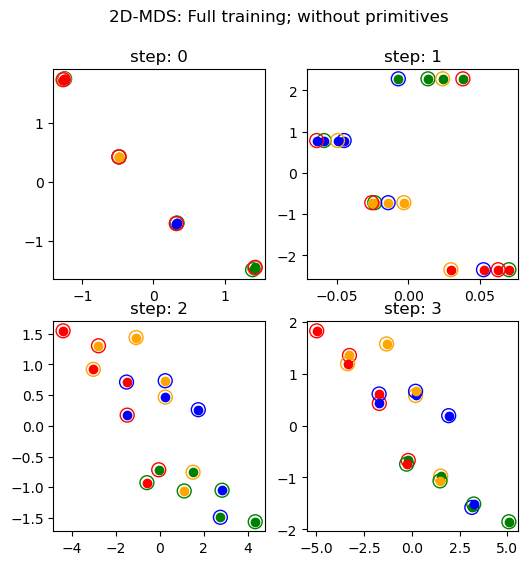

In [164]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i])

plt.suptitle('2D-MDS: Full training; without primitives')
 

Text(0.5, 0.98, '2D-MDS: Full training; with primitives')

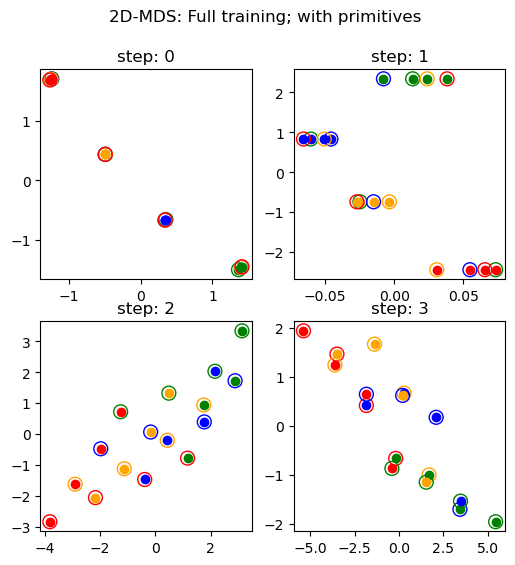

In [165]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i])

plt.suptitle('2D-MDS: Full training; with primitives')
 

## Balanced 

In [257]:
res = calculate_RDMs(res3)
rdms = res['rdms']
rdms_p = res['rdms_p']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]
truth_list = [np.array(truth_RDM(t, rdms, cue_dicts)).mean(axis=0) for t in range(4)]

no. 100% trained RNNs:  280


In [258]:
rp = generate_other(ops, all_syms) + generate_other_reverse_primitives('+', all_syms)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]


In [259]:
pca = PCA(n_components=3)
pca.fit(matlist[3])
print('no prims:   ', pca.explained_variance_ratio_)
pca = PCA(n_components=3)
pca.fit(matlist_p[3])
print('with prims:   ', pca.explained_variance_ratio_)

no prims:    [0.7228241  0.24316275 0.01235727]
with prims:    [0.71931991 0.24882807 0.01228221]


Text(0.5, 0.98, '2D-MDS: Balanced training; without primitives')

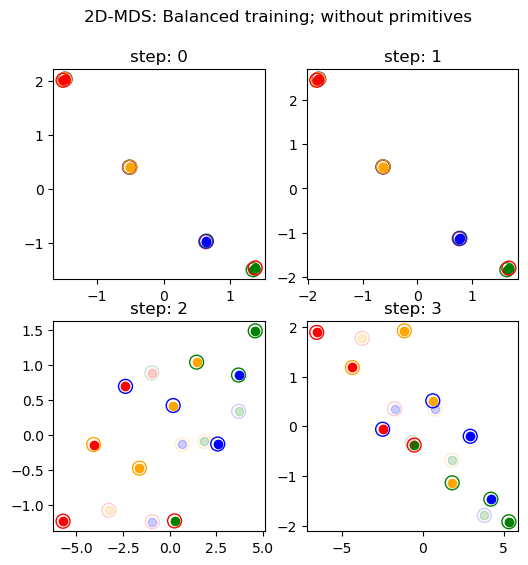

In [260]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Balanced training; without primitives')
 

Text(0.5, 0.98, '2D-MDS: Balanced training; with primitives')

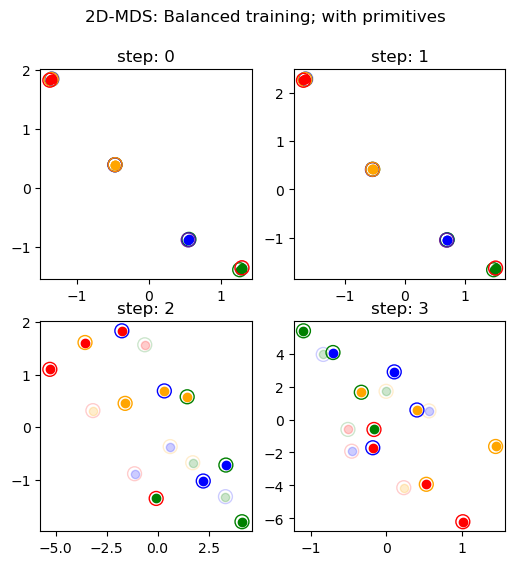

In [261]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Balanced training; with primitives')
 

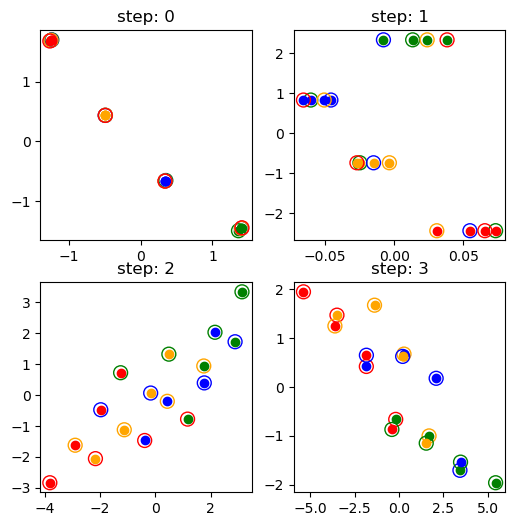

In [131]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i])

    
 

In [132]:
colors2 = ['green', 'blue', 'orange', 'red']*4
colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4

In [207]:
truth_final = np.array(truth_RDM(rdms_p, cue_dicts)).mean(axis=0)
truth_init = np.array(truth_RDM_init(rdms_p, cue_dicts)).mean(axis=0)

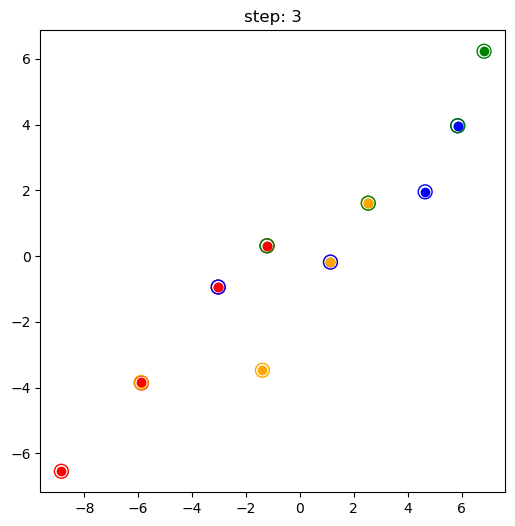

In [209]:
mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
X_transform = mds.fit_transform(truth_final)
fig, ax = plt.subplots(1,1)
ax.title.set_text('step: '+str(j))
for i in range(len(testseqs)):
    ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
    ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i])


In [194]:
pca = PCA(n_components=3)
pca.fit(truth_list[3])
print('no prims:   ', pca.explained_variance_ratio_)
pca = PCA(n_components=3)
pca.fit(truth_list[2])
print('with prims:   ', pca.explained_variance_ratio_)

no prims:    [0.71623798 0.2490412  0.01367331]
with prims:    [0.71623798 0.2490412  0.01367331]
